Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Data and import stuff

In [2]:
%tensorflow_version 2.2.1
!git clone https://github.com/arunraja-hub/Preference_Extraction.git

!pip install tensorflow==2.2.1
!pip install tf-agents==0.5.0
!pip install tensorflow-probability==0.10

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.2.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
Cloning into 'Preference_Extraction'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 1246 (delta 170), reused 192 (delta 133), pack-reused 1000
Receiving objects: 100% (1246/1246), 38.21 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (484/484), done.
     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 53.4MB/s 
     |████████████████████████████████| 3.0MB 46.7MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation

In [3]:
import tensorflow as tf
import concurrent.futures
import itertools
import os
import pickle
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import scipy
from scipy import ndimage
from sklearn import metrics
from sklearn.utils import shuffle
import io
import collections

import urllib.request
from urllib.error import HTTPError

from tf_agents.trajectories.time_step import TimeStep
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import BoundedTensorSpec
from tf_agents.networks import q_network

sys.path.append('Preference_Extraction')
from imports_data import all_load_data
import joblib

## Load Data

In [4]:
use_agent = True
env = 'doom' # valid options 'doom', 'grid'

In [5]:
# Load doom data from GCP storage, run only if env == 'doom'
# Requires GCP authentication
# Change last line to load different experience data
from google.colab import auth
auth.authenticate_user()
!gsutil cp gs://pref-extr-data/agentv29/experienceData.pkl experienceData.pkl

Copying gs://pref-extr-data/agentv29/experienceData.pkl...
- [1 files][  1.3 GiB/  1.3 GiB]   64.0 MiB/s                                   
Operation completed over 1 objects/1.3 GiB.                                      


In [6]:
if env == 'doom':
    all_raw_data = joblib.load('/content/experienceData.pkl')
else:
    all_raw_data = all_load_data("/content/Preference_Extraction/data/simple_env_1/")

In [7]:
# @title Preprocess the data into x,y training pairs
# @markdown The use_agent control which model is trained.
# @markdown All of the cells below use the data specified here.

xs, ys = [], []

for data in all_raw_data:
    for i in range(data.observation.shape[0]):
        x = np.copy(data.observation[i])
        
        if env == 'doom':
            # Doom label object is a dictionary with object_angle and distance_from_wall
            label_object = data.policy_info['satisfaction'][i]
            if len(label_object) == 0: # When label is empty, i.e. human is dead, skip frame
                continue
            else:
                y = label_object['object_angle'] < 90 or label_object['object_angle'] > 270
        else:
            y = data.policy_info['satisfaction'].as_list()[i] > -6

        xs.append(x)
        ys.append(y)

xs = np.array(xs)
ys = np.array(ys).astype(int)
xs, ys = shuffle(xs, ys)
print("xs", xs.shape, "ys", ys.shape)
print("ys 1", np.sum(ys))

xs (7830, 60, 100, 6) ys (7830,)
ys 1 1828


In [8]:
# Rebalancing data to minority class
points = xs
labels = ys

# indexes of 1s and 0s
indexes1 = [i for i in range(len(points)) if labels[i] == 1]
indexes0 = [i for i in range(len(points)) if labels[i] == 0]

# separate 0s and 1s
x0, x1, y0, y1 = points[indexes0], points[indexes1], labels[indexes0], labels[indexes1]

minority_points, minority_labels = x1, y1  # points and labels for the minority class
majority_points, majority_labels = x0, y0  # points and labels for the majority class

# get a random permutation of indexes of the majority that includes a number of indexes equal to the minority
sample_ind = np.random.permutation(len(majority_labels))[:len(minority_labels)]

# subsample the majority
majority_points, majority_labels = majority_points[sample_ind], majority_labels[sample_ind]

# concat the minority and the sub-sampled majority
xs = np.concatenate((majority_points, minority_points))
ys = np.concatenate((majority_labels, minority_labels))

print("xs", xs.shape, "ys", ys.shape)
print("ys 1", np.sum(ys))

xs (3656, 60, 100, 6) ys (3656,)
ys 1 1828


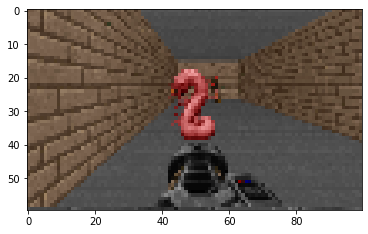

x [[[0.43529412 0.34117648 0.2627451  0.93333334 0.93333334 0.90166664]
  [0.43529412 0.34117648 0.2627451  0.93333334 0.93333334 0.90166664]
  [0.4745098  0.38039216 0.3019608  0.93333334 0.93333334 0.90166664]
  ...
  [0.4392157  0.34509805 0.26666668 0.93333334 0.93333334 0.90166664]
  [0.33333334 0.24705882 0.18039216 0.93333334 0.93333334 0.90166664]
  [0.44313726 0.34901962 0.27058825 0.93333334 0.93333334 0.90166664]]

 [[0.48235294 0.3882353  0.30980393 0.93333334 0.93333334 0.90166664]
  [0.47843137 0.38431373 0.30588236 0.93333334 0.93333334 0.90166664]
  [0.49019608 0.39607844 0.31764707 0.93333334 0.93333334 0.90166664]
  ...
  [0.4117647  0.32941177 0.2509804  0.93333334 0.93333334 0.90166664]
  [0.32941177 0.24705882 0.18039216 0.93333334 0.93333334 0.90166664]
  [0.3647059  0.28235295 0.21176471 0.93333334 0.93333334 0.90166664]]

 [[0.46666667 0.37254903 0.29411766 0.93333334 0.93333334 0.90166664]
  [0.5137255  0.41960785 0.34117648 0.93333334 0.93333334 0.90166664]
  

In [9]:
# @title Visualize and example
rand_index = random.randint(0,1000)
plt.imshow(xs[rand_index,:,:,:3])
plt.show()
print("x", xs[rand_index])
print("y", ys[rand_index])

## Training Functions

In [10]:
# @title ChannelReducer from lucid
# Copied from https://github.com/tensorflow/lucid/blob/master/lucid/misc/channel_reducer.py

# Copyright 2018 The Lucid Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Helper for using sklearn.decomposition on high-dimensional tensors.

Provides ChannelReducer, a wrapper around sklearn.decomposition to help them
apply to arbitrary rank tensors. It saves lots of annoying reshaping.
"""

import numpy as np
import sklearn.decomposition

try:
    from sklearn.decomposition.base import BaseEstimator
except AttributeError:
    from sklearn.base import BaseEstimator


class ChannelReducer(object):
  """Helper for dimensionality reduction to the innermost dimension of a tensor.

  This class wraps sklearn.decomposition classes to help them apply to arbitrary
  rank tensors. It saves lots of annoying reshaping.

  See the original sklearn.decomposition documentation:
  http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition
  """

  def __init__(self, n_components=3, reduction_alg="NMF", **kwargs):
    """Constructor for ChannelReducer.

    Inputs:
      n_components: Numer of dimensions to reduce inner most dimension to.
      reduction_alg: A string or sklearn.decomposition class. Defaults to
        "NMF" (non-negative matrix facotrization). Other options include:
        "PCA", "FastICA", and "MiniBatchDictionaryLearning". The name of any of
        the sklearn.decomposition classes will work, though.
      kwargs: Additional kwargs to be passed on to the reducer.
    """

    if not isinstance(n_components, int):
      raise ValueError("n_components must be an int, not '%s'." % n_components)

    # Defensively look up reduction_alg if it is a string and give useful errors.
    algorithm_map = {}
    for name in dir(sklearn.decomposition):
      obj = sklearn.decomposition.__getattribute__(name)
      if isinstance(obj, type) and issubclass(obj, BaseEstimator):
        algorithm_map[name] = obj
    if isinstance(reduction_alg, str):
      if reduction_alg in algorithm_map:
        reduction_alg = algorithm_map[reduction_alg]
      else:
        raise ValueError("Unknown dimensionality reduction method '%s'." % reduction_alg)


    self.n_components = n_components
    self._reducer = reduction_alg(n_components=n_components, **kwargs)
    self._is_fit = False

  @classmethod
  def _apply_flat(cls, f, acts):
    """Utility for applying f to inner dimension of acts.

    Flattens acts into a 2D tensor, applies f, then unflattens so that all
    dimesnions except innermost are unchanged.
    """
    orig_shape = acts.shape
    acts_flat = acts.reshape([-1, acts.shape[-1]])
    new_flat = f(acts_flat)
    if not isinstance(new_flat, np.ndarray):
      return new_flat
    shape = list(orig_shape[:-1]) + [-1]
    return new_flat.reshape(shape)

  def fit(self, acts):
    self._is_fit = True
    return ChannelReducer._apply_flat(self._reducer.fit, acts)

  def fit_transform(self, acts):
    self._is_fit = True
    return ChannelReducer._apply_flat(self._reducer.fit_transform, acts)

  def transform(self, acts):
    return ChannelReducer._apply_flat(self._reducer.transform, acts)

  def __call__(self, acts):
    if self._is_fit:
      return self.transform(acts)
    else:
      return self.fit_transform(acts)

  def __getattr__(self, name):
    if name in self.__dict__:
      return self.__dict__[name]
    elif name + "_" in self._reducer.__dict__:
      return self._reducer.__dict__[name+"_"]

  def __dir__(self):
    dynamic_attrs = [name[:-1]
                     for name in dir(self._reducer)
                     if name[-1] == "_" and name[0] != "_"
                    ]

    return list(ChannelReducer.__dict__.keys()) + list(self.__dict__.keys()) + dynamic_attrs

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [11]:
def get_val_auc(logs):
      for key in logs:
        if key.startswith('val_auc'):
          return logs[key]

class BestStats(tf.keras.callbacks.Callback):
  """A callback to keep track of the best val accuracy and auc seen so far."""
  def on_train_begin(self, logs):
      self.bestMetric = -float('inf')
      self.bestLogs = None
      self.bestTrain = -float('inf')
      self.num_epochs = 0

  def on_epoch_end(self, epoch, logs):
    self.num_epochs += 1
    self.bestTrain = max(self.bestTrain, logs.get('accuracy'))

    val_accuracy = logs.get('val_accuracy')
    if val_accuracy == None:
      return 

    val_auc = get_val_auc(logs)
    
    metric = (val_accuracy + val_auc) / 2.0

    if metric > self.bestMetric:
      self.bestMetric = metric
      self.bestLogs = logs

### CNN from observations

In [12]:
# @title Image model.
# @markdown Run this cell iff use_agent=False
# @markdown If you're trying to improve the accuracy of the model trained on activations, you won't care about this cell.

def get_model(reg_amount, drop_rate, reduction_alg, n_components):
  del reduction_alg, n_components

  model = tf.keras.models.Sequential([
    # This layer gets one of the color channels. It works better than using all of them.
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,tf.random.uniform((), 0,4, tf.int32)], 3), input_shape=xs.shape[1:]),
    tf.keras.layers.Conv2D(64, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_amount)),
    tf.keras.layers.Conv2D(32, 1, activation='relu', strides=1, kernel_regularizer=tf.keras.regularizers.l2(reg_amount)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(drop_rate),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_amount)),
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(.01),
                loss='binary_crossentropy',
                metrics=['accuracy',
                        tf.keras.metrics.AUC()
                        ],
                )
  return model

In [13]:
# Hyperparameters for CNN from observations
all_hparam_possibilities = [{"reg_amount": [0], "drop_rate": [0], 'reduction_alg': [None], 'n_components': [None]}]

### QNet Agent

In [14]:
cpt_name = "/content/Preference_Extraction/model_ckpt"

input_shape = [14, 16, 5]
q_net = q_network.QNetwork(input_tensor_spec=TensorSpec(shape=input_shape), action_spec=BoundedTensorSpec((), tf.int32, 0, 2), conv_layer_params = [[16, 3, 1], [32, 3, 2]], fc_layer_params = [64])
q_net.layers[0].layers[1]._name = "EncodingNetwork/conv2d_1"

latest_cpt =  tf.train.latest_checkpoint(cpt_name)
reader = tf.compat.v1.train.NewCheckpointReader(latest_cpt)
model_input = tf.keras.Input(shape=input_shape)
q_model_nested = tf.keras.models.Model(inputs=model_input, outputs=[q_net(model_input)])
q_model_nested.build(input_shape=input_shape)

In [10]:
def flatten_model(model_nested):
    def get_layers(layers):
        layers_flat = []
        for layer in layers:
            try:
                layers_flat.extend(get_layers(layer.layers))
            except AttributeError:
                layers_flat.append(layer)
        return layers_flat

    model_flat = tf.keras.models.Sequential(
        get_layers(model_nested.layers)
    )
    return model_flat

def load_weigths(model, last_layer, random=False):

    layer_map = {
        model.layers[0]: "agent/_q_network/_encoder/_postprocessing_layers/0",
        model.layers[1]: "agent/_q_network/_encoder/_postprocessing_layers/1",
    }
    if last_layer > 3:
        layer_map[model.layers[3]] = "agent/_q_network/_encoder/_postprocessing_layers/3"
    if last_layer > 4:
        layer_map[model.layers[4]] = "agent/_q_network/_q_value_layer"

    last_name_part = "/.ATTRIBUTES/VARIABLE_VALUE"
    for keras_layer, weights_bias_name in layer_map.items():
        weights = reader.get_tensor(weights_bias_name+"/kernel"+last_name_part)
        biases = reader.get_tensor(weights_bias_name+"/bias"+last_name_part)
        if random:
            initializer = tf.keras.initializers.VarianceScaling(
                scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None)
            weights = initializer(shape=weights.shape)
            biases = initializer(shape=biases.shape)
        keras_layer.set_weights([weights, biases])
    
    return model

q_model = flatten_model(q_model_nested)
q_model = load_weigths(q_model, last_layer=5, random=False)
q_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 12, 14, 16)        736       
_________________________________________________________________
EncodingNetwork/conv2d_1 (Co (None, 5, 6, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                61504     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 67,075
Trainable params: 67,075
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Verify agent it performs inference correctly
def verify_model(model, output_index):
  activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[output_index].output)
  for i in range(len(all_raw_data[0].observation)):
    single_observation = np.array([all_raw_data[0].observation[i]])

    restored_activations = activation_model(single_observation)[0]
    old_activations = all_raw_data[0].policy_info["activations"][i]
    np.testing.assert_allclose(restored_activations, old_activations, rtol=.1)

verify_model(q_model, output_index=-2)

### PPO Agent

In [15]:
!gsutil cp gs://pref-extr-data/agentv29/actorNet.keras actorNet.keras

Copying gs://pref-extr-data/agentv29/actorNet.keras...
- [1 files][ 27.6 MiB/ 27.6 MiB]                                                
Operation completed over 1 objects/27.6 MiB.                                     


In [16]:
PPO_AGENT_PATH = 'actorNet.keras'
ppo_model = tf.keras.models.load_model(PPO_AGENT_PATH)
ppo_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7200200   
_________________________________________________________________
dense_1 (Dense)              multiple                  20100     
_________________________________________________________________
logits (Dense)               multiple                  404       
Total params: 7,220,704
Trainable params: 7,220,704
Non-trainable params: 0
_________________________________________________________________


In [45]:
def load_random_weigths(model):    
    for keras_layer in model.layers:
        initializer = tf.keras.initializers.VarianceScaling(
            scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None)
        if len(keras_layer.weights) > 0:
            weights = initializer(shape=keras_layer.weights[0].shape)
            biases = initializer(shape=keras_layer.weights[1].shape)
            keras_layer.set_weights([weights, biases])

### Method to get activations DNN

In [86]:
# @title Model for training on top of the agent
# @markdown Run this cell iff use_agent=True

def get_model(agent_model, agent_type, reg_amount, drop_rate, layer_sizes, net_last_cut, 
              net_freeze, slowly_unfreezing, reduction_alg, n_components):
  del slowly_unfreezing, reduction_alg, n_components

  if agent_type == 'ppo':
        # Re-load on every train to ensure weigths degeneration
        agent_model = tf.keras.models.load_model(PPO_AGENT_PATH)

  layers = []
  for ix, layer_size in enumerate(layer_sizes):
    layers.append(tf.keras.layers.Dense(layer_size, activation='relu', 
                                        kernel_regularizer=tf.keras.regularizers.l2(reg_amount), name='post_agent_{}'.format(ix)))
    layers.append(tf.keras.layers.Dropout(drop_rate))

  for ix, _ in enumerate(agent_model.layers[:net_last_cut]):
      if ix in net_freeze:
          agent_model.layers[ix].trainable = False
      else:
          agent_model.layers[ix].trainable = True

  if agent_type == 'qnet':
    agent_layers = [agent_model.input] + agent_model.layers[:net_last_cut] 
  elif agent_type == 'ppo':
    agent_layers = agent_model.layers[:net_last_cut]

  model = tf.keras.models.Sequential(agent_layers + layers + [
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_amount), name='output')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(.01),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC()])

  random_basline = True  # Set to True for a randomly weigthed baseline
  if agent_type == 'qnet':
    return load_weigths(model, last_layer=net_last_cut, random=random_basline)
  else:
    if random_basline:
      load_random_weigths(model)  
    return model

class SlowlyUnfreezing(tf.keras.callbacks.Callback):
  """A callback to slowly unfreeze previously frozen activation layers"""
  def on_train_begin(self, logs):
      self.num_epochs = 0

  def on_epoch_end(self, epoch, logs):
    self.num_epochs += 1
    if self.num_epochs >= 50:
        self.model.layers[3].trainable = True
    if self.num_epochs >= 100:
        self.model.layers[2].trainable = True
    if self.num_epochs >= 150:
        self.model.layers[1].trainable = True
    if self.num_epochs >= 200:
        self.model.layers[0].trainable = True

In [16]:
# @title Run this cell for hparams with unsupervised feature extraction.
# @markdown Run this cell iff use_agent=True and you want unspervised feature exraction.
# TODO: fix using unsupervised feature extract now that we are training from the agent itself

all_hparam_possibilities = [
   {
    "drop_rate": [0],  
    "reg_amount": [.2],  
    "layer_sizes": [()],
    "net_last_cut": [4],
    "net_freeze": [(None,)],
    "reduction_alg": ['PCA'], 
    "n_components": [2]
   },
{
    "drop_rate": [0],  
    "reg_amount": [.2],  
    "layer_sizes": [(16, 16)],
    "net_last_cut": [4],
    "net_freeze": [(None,)],
    "reduction_alg": ['FastICA'], 
    "n_components": [2]
   }
]

In [87]:
# @title Run this cell for hparams without unsupervised feature extraction.
# @markdown Run this cell iff use_agent=True and you don't want unspervised feature exraction.
all_hparam_possibilities = [
   {
    "drop_rate": [0],  
    "reg_amount": [0],  
    "layer_sizes": [(128, 64)],
    "net_last_cut": [3],
    "net_freeze": [()],
    "slowly_unfreezing": [False],
    "reduction_alg": [None], 
    "n_components": [None]
   }
]

# Training code

In [88]:
agent_type = 'ppo'
agent_model = ppo_model

In [89]:
# Run this to reproduce the original results.
num_train = 500
num_val = 1000
epochs = 500
num_repeat = 1

In [ ]:
# Run this to train on 10k data instead.
num_train = 10000
num_val = 1000
epochs = 400
num_repeat = 5

In [90]:
# @title Train the model
# @markdown This tries all the combinations of hparams and picks the best one.
# @markdown For each combination of hparams, it averages over num_repeat different train val splits.
# @markdown It re runs the best hyperparameters at the end.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print("use_agent:", use_agent, "num_train:", num_train, "epochs", epochs)
if num_train > 50:
  print("More than 50 train data!!!!!!!!")

# each item in all_hparam_possibilities specifies valid hyper params to try. Put parameters that don't make sense together in separate lists.

hparam_combinations = []
for hparam_possibilities in all_hparam_possibilities:
  hparam_keys, hparam_values = zip(*hparam_possibilities.items())
  hparam_combinations.extend([dict(zip(hparam_keys, v)) for v in itertools.product(*hparam_values)])
random.shuffle(hparam_combinations)
print("len(hparam_combinations)", len(hparam_combinations), "hparam_combinations", hparam_combinations)

def modify_x_for_reduce(xs):
  reshaped_x = np.reshape(xs, [xs.shape[0], -1])
  # Make everything positive because some reductions don't work with negatives.
  reshaped_x -= np.min(reshaped_x)
  return reshaped_x

def unsup_exstract(xs, reg_amount, drop_rate, layer_sizes, reduction_alg, n_components, net_last_cut, net_freeze):
  del reg_amount, drop_rate, layer_sizes, net_last_cut, net_freeze

  print("Using unsupervised feature extraction.")

  dim_reduct_model = ChannelReducer(reduction_alg=reduction_alg, n_components=n_components)
  xs = dim_reduct_model.fit_transform(modify_x_for_reduce(xs))
  return xs

def train_best_logs(xs, ys, num_val, do_summary, hparams, get_model):
  """Trains the model and retruns the logs of the best epoch. randomly splits the train and val data before training."""
  tf.keras.backend.clear_session()
  if use_agent:
    model = get_model(agent_model, agent_type, **hparams)
  else:
    model = get_model(**hparams)
  xs, ys = shuffle(xs, ys)

  xs_val = xs[num_train:num_train+num_val]
  ys_val = ys[num_train:num_train+num_val]
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=0)
  best_stats = BestStats()
  if hparams['slowly_unfreezing']:
      slowly_unfreezing = SlowlyUnfreezing()
  else:
      slowly_unfreezing = tf.keras.callbacks.Callback()
  model.fit(xs[:num_train], ys[:num_train], epochs=epochs, batch_size=128, validation_freq=10, 
            callbacks=[best_stats, early_stopping, slowly_unfreezing], validation_data=(xs_val, ys_val), verbose=0)
  if do_summary:
    model.summary()
    print("best train accuracy:", best_stats.bestTrain)
    print("Number of epochs:", best_stats.num_epochs)
  return best_stats.bestLogs

def multiple_train_ave(hparams):
  """Trains the model multiple times with the same parameters and returns the average metrics"""
  start = time.time()
  all_val_auc = []
  all_val_accuracy = []

  if hparams['reduction_alg'] != None:
    xs_for_train = unsup_exstract(xs, **hparams)
  else:
    xs_for_train = xs

  do_summary = True
  for i in range(num_repeat):
    logs = train_best_logs(xs_for_train, ys, num_val, do_summary, hparams, get_model)
    all_val_auc.append(get_val_auc(logs))
    all_val_accuracy.append(logs.get('val_accuracy'))
    do_summary = False 

  mean_val_auc = np.mean(all_val_auc)
  mean_val_accuracy = np.mean(all_val_accuracy)
  metric = (mean_val_auc + mean_val_accuracy) / 2.0
  print_data = ("mean_val_auc", mean_val_auc, "mean_val_accuracy", mean_val_accuracy, 
                "metric", metric, "val_auc_std", np.std(all_val_auc), "val_accuracy_std", np.std(all_val_accuracy))

  end = time.time()
  print("Seconds per hyperparam config", end - start)
  # GPU: ('Seconds per hyperparam config', 16.970870971679688)

  return metric, print_data

best_metric = -float('inf')

run_num = 0
for hparams in hparam_combinations:
  print("hparams", hparams)

  metric, print_data = multiple_train_ave(hparams)

  print(print_data)
  if metric > best_metric:
    best_metric = metric
    best_print_data = print_data
    best_hparams = hparams

  run_num += 1
  print("fract done", run_num/float(len(hparam_combinations)))
  print
  print("==============================================================================================")
  print
  sys.stdout.flush()

print("best_hparams", best_hparams)
print("best results", best_print_data)
print("Retraining on the best_hparams to make sure we didn't just get good results by random chance.")

_, print_data = multiple_train_ave(best_hparams)
print("Result of retrain on the best hyperparameters", print_data)


use_agent: True num_train: 500 epochs 500
More than 50 train data!!!!!!!!
len(hparam_combinations) 1 hparam_combinations [{'drop_rate': 0, 'reg_amount': 0, 'layer_sizes': (128, 64), 'net_last_cut': 3, 'net_freeze': (), 'slowly_unfreezing': False, 'reduction_alg': None, 'n_components': None}]
hparams {'drop_rate': 0, 'reg_amount': 0, 'layer_sizes': (128, 64), 'net_last_cut': 3, 'net_freeze': (), 'slowly_unfreezing': False, 'reduction_alg': None, 'n_components': None}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7200200   
_________________________________________________________________
dense_1 (Dense)              multiple                  20100     
_______________________________________________